In [63]:
# Importing Libraries
import ast
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt  
import seaborn as sns

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [64]:
df_DA_US = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'United States')].copy()

In [65]:
df_DA_US = df_DA_US.dropna(subset=['salary_year_avg'])

df_DA_US_exploded = df_DA_US.explode('job_skills')

df_DA_US_exploded[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
109,89000.0,python
109,89000.0,r
109,89000.0,alteryx
109,89000.0,tableau
180,90250.0,excel


In [66]:
df_DA_skills = df_DA_US_exploded.groupby(['job_skills'])['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False) 

df_DA_skills = df_DA_skills.rename(columns={'count':'skill_count', 'median':'median_salary'})

DA_job_count = len(df_DA_US)

df_DA_skills['skill_percent'] =  df_DA_skills['skill_count'] / DA_job_count * 100

skill_limit = 5

df_DA_high_demand = df_DA_skills[df_DA_skills['skill_percent'] > skill_limit]

df_DA_high_demand  

,skill_count,median_salary,skill_percent
job_skills,,,
sql,2508,91000.00,57.655172
excel,1808,84392.00,41.563218
python,1431,97500.00,32.896552
tableau,1364,92875.00,31.356322
sas,926,90000.00,21.287356
r,893,92500.00,20.528736
power bi,838,90000.00,19.264368
powerpoint,462,85000.00,10.620690
word,461,81194.75,10.597701


In [67]:
df_tech = df_DA_US['job_type_skills'].copy()

df_tech = df_tech.drop_duplicates()

df_tech = df_tech.dropna()

tech_dict = {}
for row in df_tech:
    row_dict = ast.literal_eval(row)
    for key, value in row_dict.items():
        if key in tech_dict:
            tech_dict[key] += value
        else:
            tech_dict[key] = value

for key, value in tech_dict.items():
    tech_dict[key] = list(set(value))

tech_dict 

{'analyst_tools': ['spss',
  'spreadsheet',
  'dax',
  'excel',
  'microstrategy',
  'alteryx',
  'ssis',
  'splunk',
  'powerpoint',
  'qlik',
  'sheets',
  'sharepoint',
  'word',
  'power bi',
  'sap',
  'ssrs',
  'tableau',
  'cognos',
  'outlook',
  'ms access',
  'visio',
  'looker',
  'sas'],
 'programming': ['t-sql',
  'crystal',
  'sass',
  'bash',
  'mongo',
  'scala',
  'ruby',
  'sql',
  'erlang',
  'swift',
  'nosql',
  'c++',
  'sas',
  'typescript',
  'php',
  'c#',
  'html',
  'go',
  'matlab',
  'python',
  'solidity',
  'cobol',
  'r',
  'vba',
  'java',
  'perl',
  'fortran',
  'vb.net',
  'javascript',
  'css',
  'julia',
  'powershell',
  'rust',
  'assembly',
  'golang',
  'mongodb',
  'visual basic',
  'c',
  'no-sql',
  'shell',
  'dart'],
 'cloud': ['snowflake',
  'vmware',
  'aws',
  'watson',
  'colocation',
  'bigquery',
  'ibm cloud',
  'firebase',
  'databricks',
  'oracle',
  'gcp',
  'redshift',
  'aurora',
  'azure'],
 'os': ['linux', 'unix', 'arch', 'm

In [68]:
data = [(key, val) for key, val in tech_dict.items()]

df_tech_dict = pd.DataFrame(data, columns=['technology', 'skills'])

df_tech_dict = df_tech_dict.explode('skills')

df_tech_dict

,technology,skills
0,analyst_tools,spss
0,analyst_tools,spreadsheet
0,analyst_tools,dax
0,analyst_tools,excel
0,analyst_tools,microstrategy
...,...,...
9,sync,webex
9,sync,microsoft teams
9,sync,unify
9,sync,wire


In [69]:
df_plot = df_DA_high_demand.merge(df_tech_dict, left_on='job_skills', right_on='skills')
df_plot

,skill_count,median_salary,skill_percent,technology,skills
0,2508,91000.00,57.655172,programming,sql
1,1808,84392.00,41.563218,analyst_tools,excel
2,1431,97500.00,32.896552,programming,python
3,1364,92875.00,31.356322,analyst_tools,tableau
4,926,90000.00,21.287356,analyst_tools,sas
5,926,90000.00,21.287356,programming,sas
6,893,92500.00,20.528736,programming,r
7,838,90000.00,19.264368,analyst_tools,power bi
8,462,85000.00,10.620690,analyst_tools,powerpoint
9,461,81194.75,10.597701,analyst_tools,word


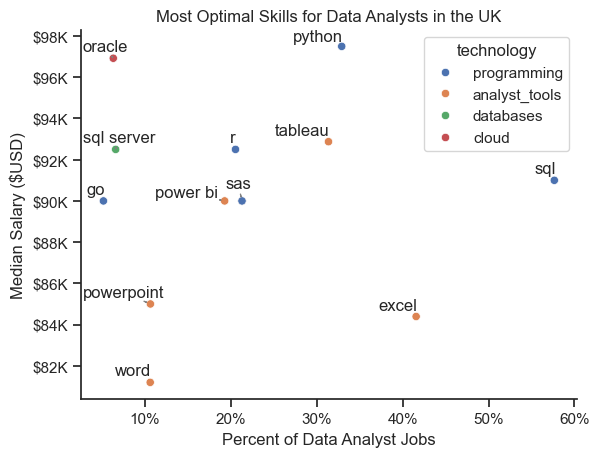

In [70]:
from adjustText import adjust_text

sns.scatterplot(
    data=df_plot, 
    x='skill_percent', 
    y='median_salary',
    hue='technology'
)
sns.despine()
sns.set_theme(style='ticks')
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Salary ($USD)')  
plt.title('Most Optimal Skills for Data Analysts in the UK')

from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K')) 
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

texts = []
for i, txt in enumerate(df_DA_high_demand.index):
    texts.append(plt.text(df_DA_high_demand['skill_percent'].iloc[i], df_DA_high_demand['median_salary'].iloc[i], txt, ha='right', va='bottom'))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))


plt.show()